In [1]:
import torch
import torch.nn as nn
import torch.optim as optim

In [2]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

In [3]:
from utils import load_cifar10, load_cifar100,load_tinyimagenet

In [4]:
classes = ('plane', 'car', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck')

In [5]:
# load cifar10 data
trainloader, testloader = load_cifar10(data_dir="../data/cifar10", batch_size=128, 
                                       test_batch = 128,train_shuffle=True)

Files already downloaded and verified
Files already downloaded and verified


In [6]:
# load dataloader for steal
stealloader,_ = load_cifar100(data_dir="../data/cifar100", batch_size=128, train_shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


In [7]:
# load tinyimagenet for outlier exposure
outlier_loader = load_tinyimagenet(data_dir="../data/tiny-imagenet-200", 
                                   batch_size=128, train_shuffle=True)

# Train Model

In [8]:
from cifar_models import Net, Net_logit, small_Net3, AttackNet,Net3, small_Net2

In [9]:
from utils import Net_softmax, Net_tsoftmax

In [31]:
import os
net_logit = Net3()
net_logit.load_state_dict(torch.load("../results/cifar_orig_taylor.pth"))
net = Net_tsoftmax(net_logit)
net_fake = small_Net2()
net_fake.load_state_dict(torch.load("../results/cifar_fake_small_taylor_ML.pth"))
# net_fake = Net_softmax(net_fake)
net_fake_swd = small_Net2()
net_fake_swd.load_state_dict(torch.load("../results/cifar_fake_small_taylor_ML_swd.pth"))

net_logit_fake = small_Net3()
net_logit_fake.load_state_dict(torch.load("../results/cifar_fake_small_taylor_ML.pth"))
net_logit_swd = small_Net3()
net_logit_swd.load_state_dict(torch.load("../results/cifar_fake_small_taylor_ML_swd.pth"))
# net_fake_swd2 = small_Net2()
# net_fake_swd2.load_state_dict(torch.load("../results/sr_cifar_fake_taylor_swd.pth"))
# net_fake_swd2 = fake_swd

# net_fake_swd = Net_softmax(net_fake_swd)

<All keys matched successfully>

In [33]:
from utils import train_model_CE, Net_softmax, CombNet, CombNet_soft, CombNetHE

In [82]:
import numpy as np
tau_list = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
tau = 0.6
nu = 1000.0
comb_net = CombNetHE(net,net_fake,tau)
comb_net_swd = CombNetHE(net,net_fake_swd,tau)
# comb_net_swd2 = CombNet(net_HE,net_fake_swd2,tau)
# comb_net_soft = CombNet_soft(net,net_fake,tau, nu)
# comb_net_soft_swd = CombNet_soft(net,net_fake_swd,tau, nu)

In [83]:
criterion = nn.CrossEntropyLoss()
from utils import test_model
print(test_model(comb_net.to(device), testloader, criterion,device, 100.0))
comb_net.cpu()
print(test_model(comb_net_swd.to(device), testloader, criterion,device, 100.0))
comb_net_swd.cpu()

(tensor(1.7780), tensor(71.1900))
(tensor(1.7740), tensor(71.5400))


CombNetHE(
  (net_orig): Net_tsoftmax(
    (model): Net3(
      (pool): AvgPool2d(kernel_size=2, stride=2, padding=0)
      (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (classifier): Sequential(
        (0): Linear(in_features=2048, out_features=256, bias=True)
        (1): Linear(in_features=256, out_features=10, bias=True)
      )
    )
  )
  (net_fake): small_Net2(
    (pool): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (classifier): Sequential(
      (0): Linear(in_features=8192, out_features=128, bias=True)
      (1): Linear(in_features=128, out_features=10, bias=True)
    )
  )
)

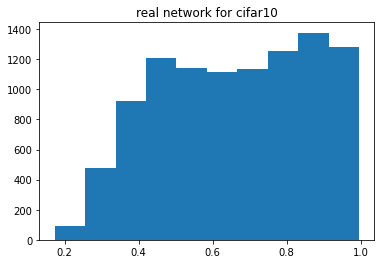

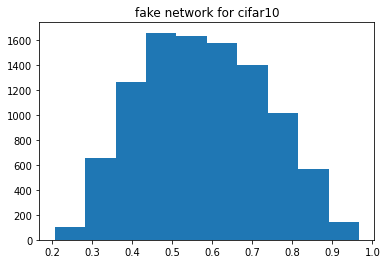

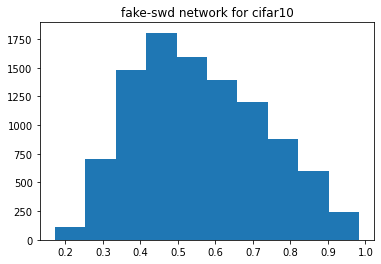

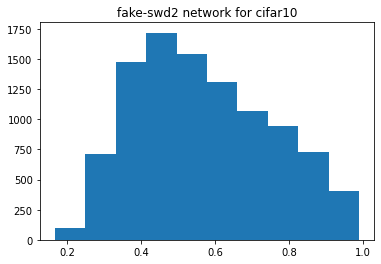

In [46]:
from utils import maxclass_hist, prediction_hist
maxclass_hist(testloader, net_HE, device, plt_title="real network for cifar10",
              clipping=True, clip_vals=[None, 30])
maxclass_hist(testloader, net_fake, device, plt_title="fake network for cifar10")
maxclass_hist(testloader, net_fake_swd, device, plt_title="fake-swd network for cifar10")
maxclass_hist(testloader, net_fake_swd2, device, plt_title="fake-swd2 network for cifar10")
# maxclass_hist(stealloader, net, device, plt_title="logit network for cifar100",
#               clipping=True, clip_vals=[None, 30])
# maxclass_hist(outlier_loader, net, device, plt_title="logit network for tinyimagenet",
#               clipping=True, clip_vals=[None, 30])

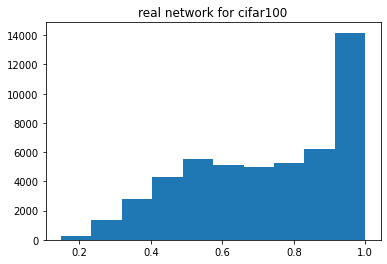

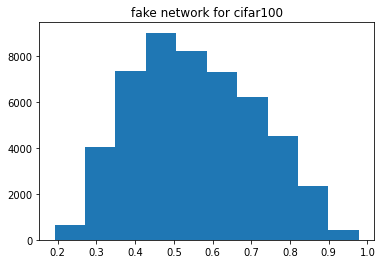

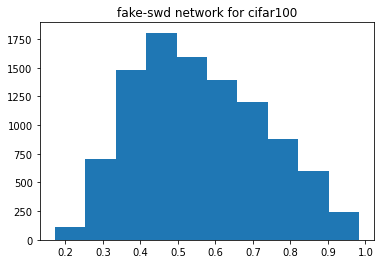

In [55]:
from utils import maxclass_hist, prediction_hist
maxclass_hist(stealloader, net, device, plt_title="real network for cifar100",
              clipping=True, clip_vals=[None, 30])
maxclass_hist(stealloader, net_fake, device, plt_title="fake network for cifar100")

maxclass_hist(testloader, net_fake_swd, device, plt_title="fake-swd network for cifar100")
# maxclass_hist(testloader, net_fake_swd2, device, plt_title="fake-swd2 network for cifar10")
# maxclass_hist(stealloader, net, device, plt_title="logit network for cifar100",
#               clipping=True, clip_vals=[None, 30])
# maxclass_hist(outlier_loader, net, device, plt_title="logit network for tinyimagenet",
#               clipping=True, clip_vals=[None, 30])

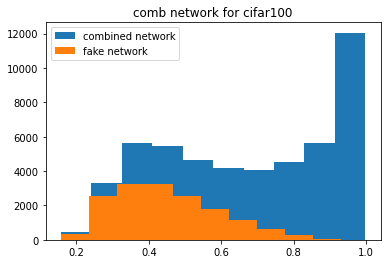

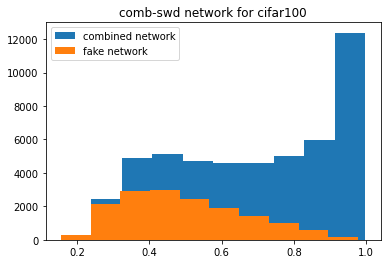

In [84]:
from utils import maxclass_hist_comb
# maxclass_hist_comb(stealloader, comb_net_soft, device, plt_title="comb-soft network for cifar100")
maxclass_hist_comb(stealloader, comb_net, device, plt_title="comb network for cifar100")
maxclass_hist_comb(stealloader, comb_net_swd, device, plt_title="comb-swd network for cifar100")
# maxclass_hist_comb(stealloader, comb_net_swd2, device, plt_title="comb-swd2 network for cifar100")

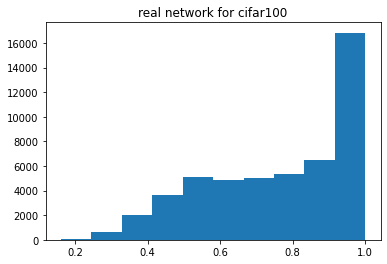

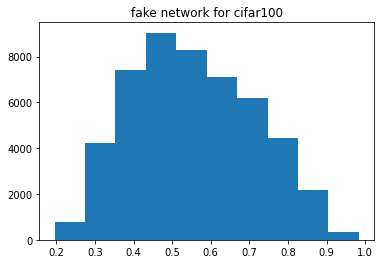

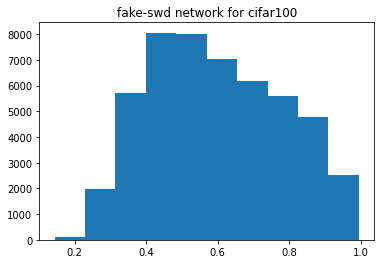

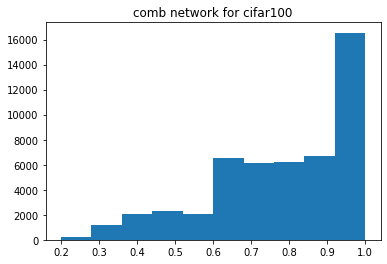

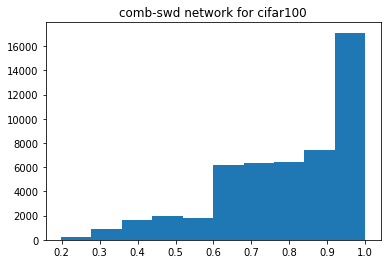

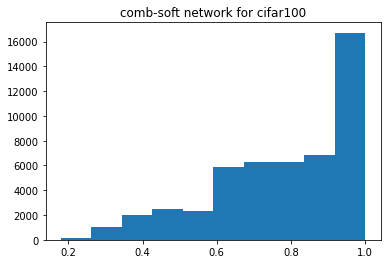

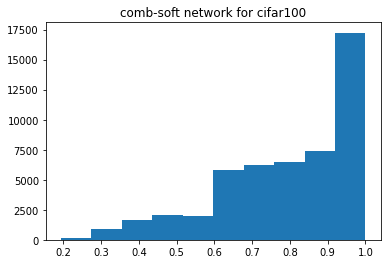

In [16]:
maxclass_hist(stealloader, net, device, plt_title="real network for cifar100")
maxclass_hist(stealloader, net_fake, device, plt_title="fake network for cifar100")
maxclass_hist(stealloader, net_fake_swd, device, plt_title="fake-swd network for cifar100")
maxclass_hist(stealloader, comb_net, device, plt_title="comb network for cifar100")
maxclass_hist(stealloader, comb_net_swd, device, plt_title="comb-swd network for cifar100")
maxclass_hist(stealloader, comb_net_soft, device, plt_title="comb-soft network for cifar100")
maxclass_hist(stealloader, comb_net_soft_swd, device, plt_title="comb-soft network for cifar100")

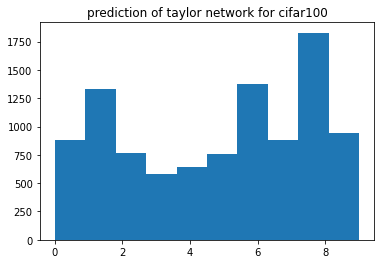

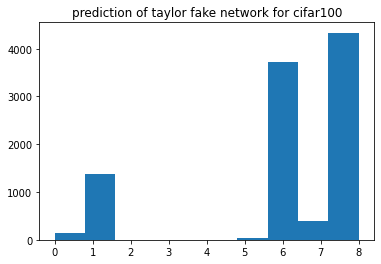

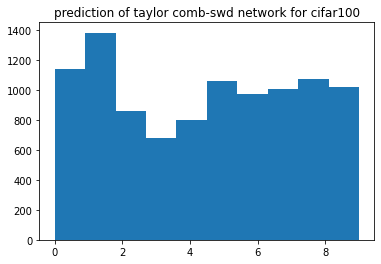

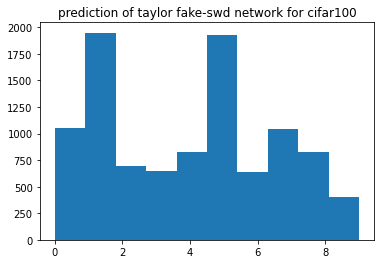

In [46]:
from utils import prediction_hist
prediction_hist(testloader, comb_net, device, plt_title="prediction of taylor network for cifar10")
prediction_hist(testloader, net_fake, device, plt_title="prediction of taylor fake network for cifar10")
prediction_hist(testloader, comb_net_swd, device, plt_title="prediction of taylor comb-swd network for cifar10")
prediction_hist(testloader, net_fake_swd, device, plt_title="prediction of taylor fake-swd network for cifar10")
# prediction_hist(testloader, comb_net_swd2, device, plt_title="prediction of logit network for cifar100")


In [78]:
import matplotlib.pyplot as plt
import numpy as np
def prediction_hist_comb(data_loader, comb_model, device, plt_title = None,bins=10):
    comb_model.to(device).eval()
    max_idxs = torch.tensor([])
    f_idxs = torch.tensor([])
    with torch.no_grad():
        for data in data_loader:
            outs = comb_model(data[0].to(device))
            _,idxs = outs.cpu().detach().max(axis=1)
            max_idxs = torch.cat((max_idxs,idxs))
            outs_f = (torch.max(comb_model.net_orig(data[0].to(device)).cpu().detach(),dim=1).values<=comb_model.tau).flatten()
#             print(outs_f)
            f_idxs = torch.cat((f_idxs, outs_f))
#             print(f_idxs.type(torch.bool))
            del data, outs,idxs
#     print(f_idxs)
    f_idxs = f_idxs.type(torch.bool)
    if plt_title:
        plt.title(plt_title)
    plt.hist(max_idxs.numpy().flatten(), bins=bins,label="combined network")
    plt.hist(max_idxs.numpy().flatten()[f_idxs.numpy().flatten()], bins=bins, label="fake network")
    plt.legend(loc ='upper left')
    plt.show()
    comb_model.cpu()

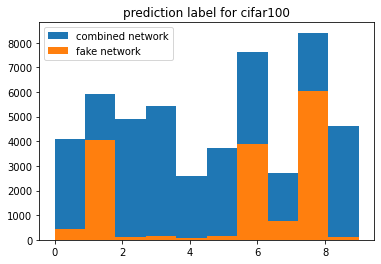

In [81]:
prediction_hist_comb(stealloader, comb_net, device, plt_title="prediction label for cifar100")

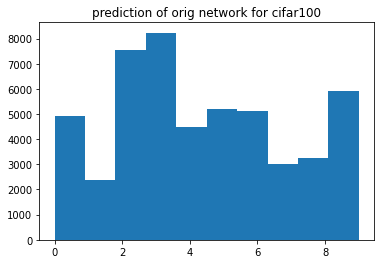

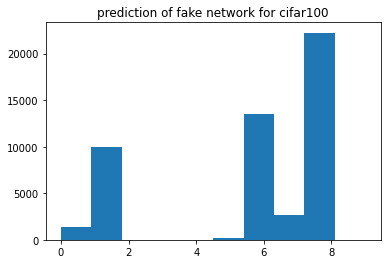

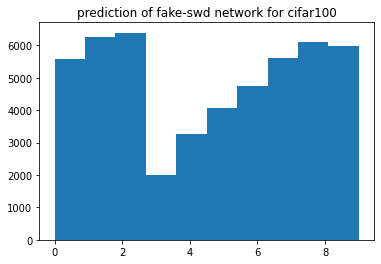

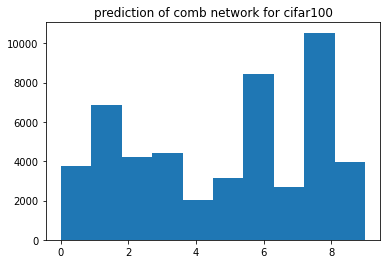

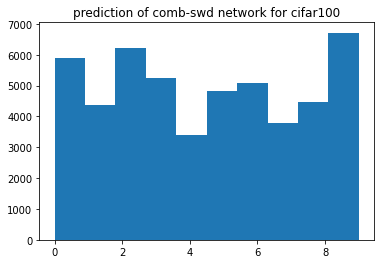

In [48]:
# prediction_hist(testloader, net, device, plt_title="prediction of logit network for cifar10")
prediction_hist(stealloader, net, device, plt_title="prediction of orig network for cifar100")
prediction_hist(stealloader, net_fake, device, plt_title="prediction of fake network for cifar100")
prediction_hist(stealloader, net_fake_swd, device, plt_title="prediction of fake-swd network for cifar100")
prediction_hist(stealloader, comb_net, device, plt_title="prediction of comb network for cifar100")
prediction_hist(stealloader, comb_net_swd, device, plt_title="prediction of comb-swd network for cifar100")
# prediction_hist(stealloader, comb_net_swd2, device, plt_title="prediction of logit network for cifar100")
# prediction_hist(outlier_loader, net, device, plt_title="prediction of logit network for tinyimagenet")

## train original model

In [25]:
from utils import train_model_NLL

In [26]:
net = Net2()
net_optim = optim.Adam(net.parameters(), lr=0.0001)

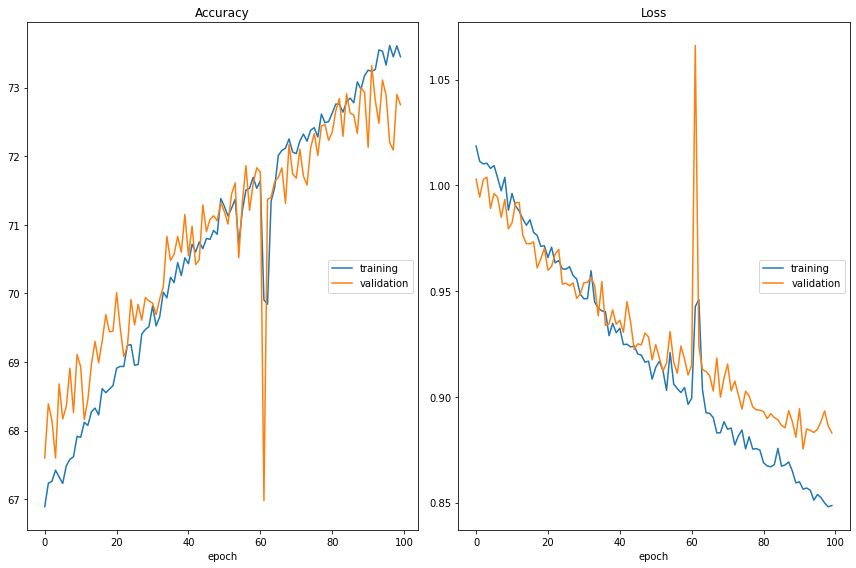

Accuracy
	training         	 (min:   66.890, max:   73.614, cur:   73.450)
	validation       	 (min:   66.980, max:   73.320, cur:   72.750)
Loss
	training         	 (min:    0.848, max:    1.019, cur:    0.849)
	validation       	 (min:    0.875, max:    1.066, cur:    0.883)


In [29]:
net, logs_net = train_model_NLL(net, trainloader, net_optim, device, epochs=100, 
                 test_loader = testloader, save_dir = "../results",save_model="sr_cifar_orig_net.pth")

In [41]:
from utils import test_model
print(test_model(net.to(device),testloader,nn.NLLLoss(), device,100.0))
print(test_model(net_HE.to(device),testloader,nn.NLLLoss(), device,100.0))
net.cpu()
net_HE.cpu()

(tensor(-0.5326), tensor(72.7500))
(tensor(-0.5936), tensor(76.6900))


Net2(
  (pool): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (classifier): Sequential(
    (0): Linear(in_features=2048, out_features=256, bias=True)
    (1): Linear(in_features=256, out_features=10, bias=True)
  )
)

### load trained model

In [11]:
import os
net = Net()
net.load_state_dict(torch.load(os.path.join("../results","net_taylor.pth")))

<All keys matched successfully>

### maximum score histogram

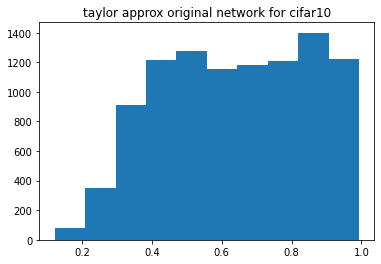

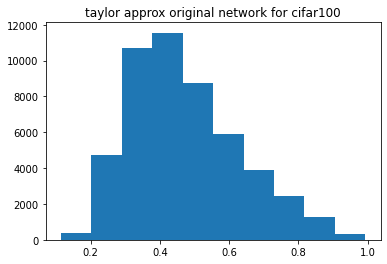

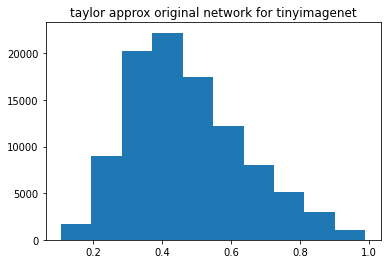

In [14]:
from utils import maxclass_hist, prediction_hist
maxclass_hist(testloader, net, device, plt_title="taylor approx original network for cifar10")
maxclass_hist(stealloader, net, device, plt_title="taylor approx original network for cifar100")
maxclass_hist(outlier_loader, net, device, plt_title="taylor approx original network for tinyimagenet")

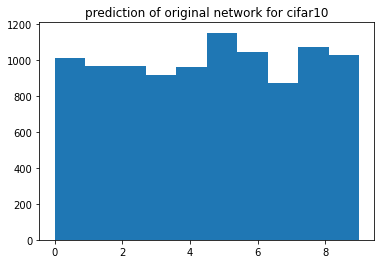

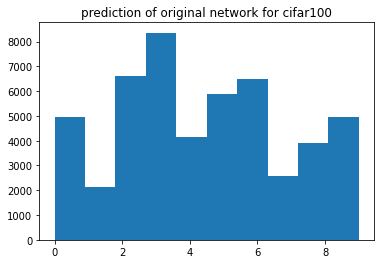

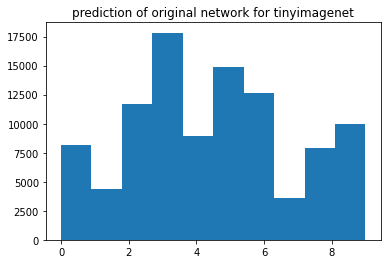

In [16]:
prediction_hist(testloader, net, device, plt_title="prediction of original network for cifar10")
prediction_hist(stealloader, net, device, plt_title="prediction of original network for cifar100")
prediction_hist(outlier_loader, net, device, plt_title="prediction of original network for tinyimagenet")

## Outlier Exposure

In [11]:
import copy
from utils import train_model_with_oe_KL

In [12]:
net_oe = copy.deepcopy(net)

In [13]:
loss_in = nn.NLLLoss()
loss_out = nn.KLDivLoss(reduction='batchmean')
optimizer_oe = optim.Adam(net_oe.parameters(), lr=0.0001)

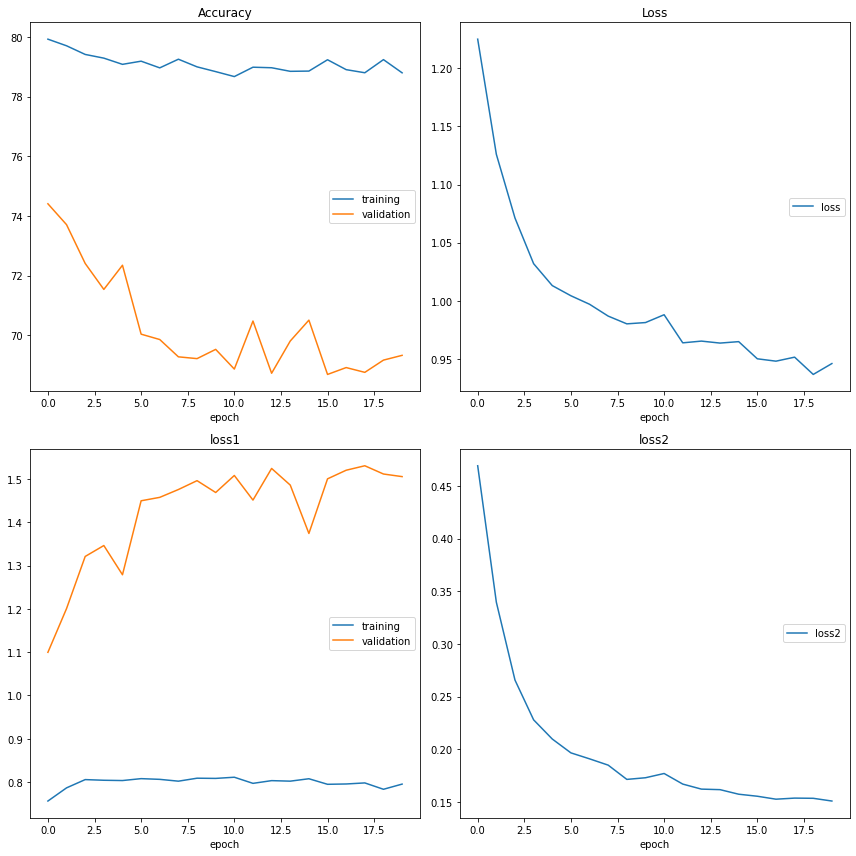

Accuracy
	training         	 (min:   78.674, max:   79.928, cur:   78.800)
	validation       	 (min:   68.690, max:   74.410, cur:   69.330)
Loss
	loss             	 (min:    0.937, max:    1.225, cur:    0.946)
loss1
	training         	 (min:    0.756, max:    0.811, cur:    0.795)
	validation       	 (min:    1.100, max:    1.531, cur:    1.505)
loss2
	loss2            	 (min:    0.151, max:    0.469, cur:    0.151)


In [14]:
## oe loss 가중치 얼마줄 것인가를 weight_out 에서 조정!
net_oe, logs_oe = train_model_with_oe_KL(net_oe, trainloader, outlier_loader, optimizer_oe, device, 
                          loss_in, loss_out, weight_out=0.1, epochs=20,pred_prob = True, test_loader = testloader,
                          save_dir = '../results', save_model="cifar_oe_net.pth")

### Load model

In [26]:
net_oe = Net()
net_oe.load_state_dict(torch.load(os.path.join("../results","cifar_oe_net.pth")))

<All keys matched successfully>

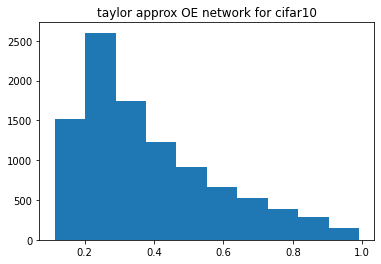

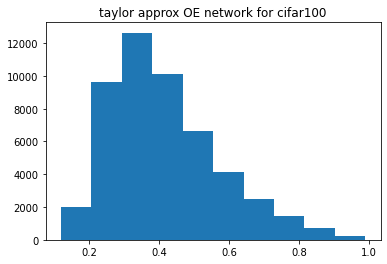

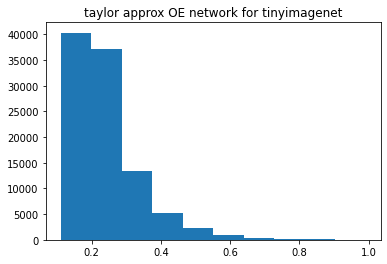

In [15]:
from utils import maxclass_hist, prediction_hist

maxclass_hist(testloader, net_oe, device, plt_title="taylor approx OE network for cifar10")
maxclass_hist(stealloader, net_oe, device, plt_title="taylor approx OE network for cifar100")
maxclass_hist(outlier_loader, net_oe, device, plt_title="taylor approx OE network for tinyimagenet")

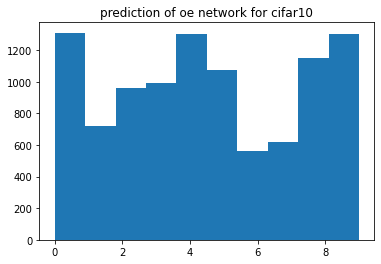

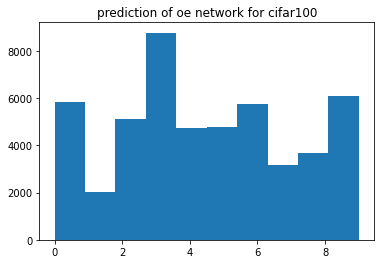

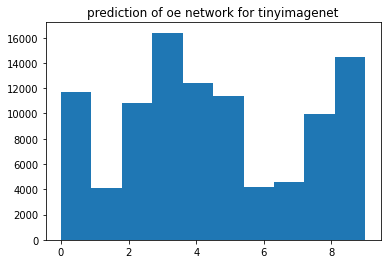

In [16]:
prediction_hist(testloader, net_oe, device, plt_title="prediction of oe network for cifar10")
prediction_hist(stealloader, net_oe, device, plt_title="prediction of oe network for cifar100")
prediction_hist(outlier_loader, net_oe, device, plt_title="prediction of oe network for tinyimagenet")

# Train Fake Net

## Taylor NLL + SWAE

In [19]:
from utils import train_swd_fakenet_NLL, make_st_loader,train_swd_fakenet_CE
from cifar_models import small_Net3

In [17]:
fake_logit_swd = small_Net3()
optim_swd = optim.Adam(fake_logit_swd .parameters(),lr=0.0001)

In [15]:
st_loader = make_st_loader(net_logit, trainloader, device)

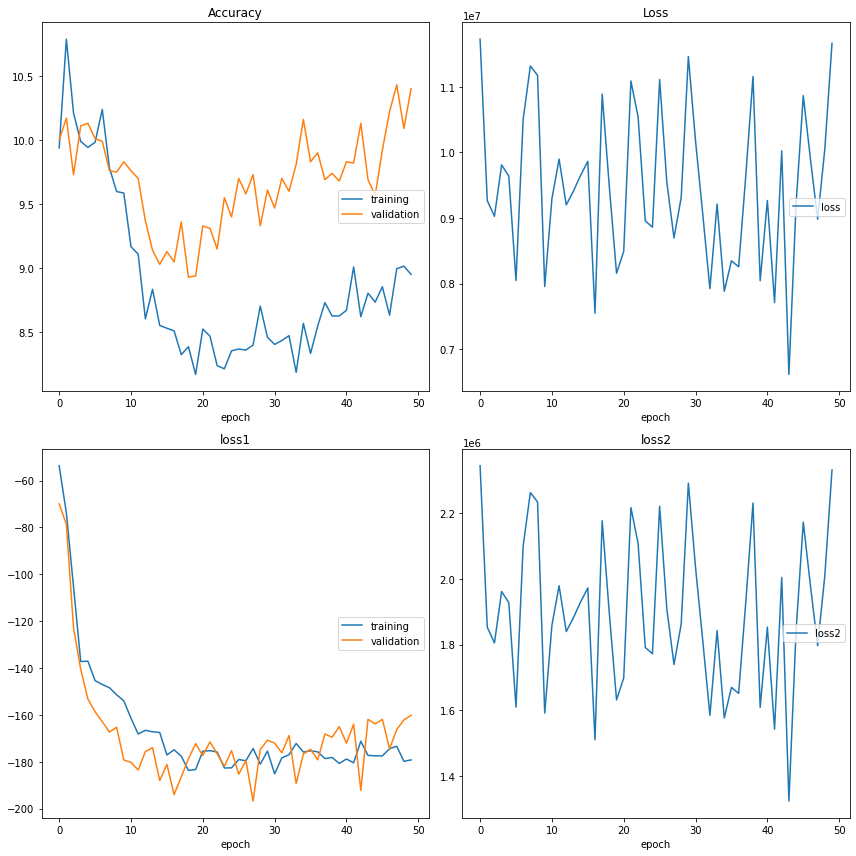

Accuracy
	training         	 (min:    8.172, max:   10.786, cur:    8.952)
	validation       	 (min:    8.930, max:   10.430, cur:   10.400)
Loss
	loss             	 (min: 6616745.000, max: 11724694.000, cur: 11661441.000)
loss1
	training         	 (min: -185.132, max:  -53.703, cur: -179.177)
	validation       	 (min: -196.732, max:  -69.940, cur: -160.150)
loss2
	loss2            	 (min: 1323385.500, max: 2344951.250, cur: 2332323.500)


In [20]:
fake_logit_swd, flogit_logs = train_swd_fakenet_CE(fake_logit_swd, trainloader, st_loader, optim_swd, device, epochs=50, 
                                                loss_weights=[-0.1,5.0],test_loader = testloader,
                                                save_dir='../results', save_model="sr_cifar_fake_logit_HE_swd.pth")

In [35]:
torch.save(fake_swd, os.path.join("../results","sr_cifar_fake_taylor_swae.pth"))

### load model

In [15]:
import os
fake_swd.load_state_dict(torch.load(os.path.join("../results","sr_cifar_fake_taylor_swae.pth")))

<All keys matched successfully>

In [26]:
from utils import get_prediction
def apply_taylor_softmax(x,emph=1.0):
    x = (1+x+0.5*x**2)**emph                                   
    x /= torch.sum(x,axis=1).view(-1,1)
    return x
class Net_tsoftmax(nn.Module):
    def __init__(self, model,temp = 32.0,emph=4.0):
        super(Net_tsoftmax, self).__init__()
        self.model = model
        self.temp = temp
        self.emph = emph
    def forward(self,x):
        x = self.model(x)
        x = apply_taylor_softmax(x/self.temp,self.emph)
        return x

In [27]:
# fake_swd = Net_tsoftmax(fake_logit_swd)
net_HE = Net_tsoftmax(net_logit)
net_swd = Net_tsoftmax(net_logit_swd)
net_fake2 = Net_tsoftmax(net_logit_fake)

In [22]:
preds = get_prediction(net_HE, testloader, device)
preds_fake = get_prediction(net_swd, testloader, device)
preds_fake2 = get_prediction(net_fake2, testloader, device)

In [25]:
preds

tensor([[1.4631e-03, 1.8053e-06, 2.7450e-06,  ..., 1.6898e-08, 2.6750e-07,
         2.0419e-07],
        [2.2981e-06, 6.1589e-02, 2.7237e-09,  ..., 1.5333e-10, 2.1668e-02,
         1.5719e-10],
        [1.4784e-04, 3.5279e-04, 1.9007e-06,  ..., 4.2068e-05, 2.1308e-02,
         3.4003e-05],
        ...,
        [3.8313e-07, 3.9321e-07, 1.0805e-05,  ..., 9.0024e-05, 6.1987e-06,
         9.1909e-07],
        [4.6829e-03, 7.3914e-02, 7.3981e-07,  ..., 1.8632e-08, 2.2231e-07,
         1.4388e-09],
        [8.1094e-06, 6.7541e-06, 1.1650e-06,  ..., 5.4995e-02, 4.6839e-06,
         3.0100e-06]])

In [127]:
logits = get_prediction(net_logit, testloader, device)
logits_fake = get_prediction(fake_logit_swd, testloader, device)

In [18]:
logits100 = get_prediction(net_logit, stealloader, device)

In [19]:
z = logits100/32

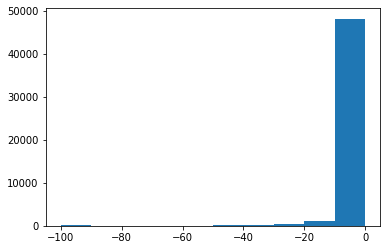

In [172]:
plt.hist(torch.clamp(torch.min(z,dim=1)[0],-100,0).numpy())
plt.show()

In [174]:
(np.sum(logits100.numpy()<-32)+np.sum(logits100.numpy()>1000))/(len(logits100)*10)

0.08258

In [175]:
(np.sum(logits100.numpy()<-50))/(len(logits100)*10)

0.046364

In [176]:
import numpy as np
np.exp(z)

<ipython-input-176-e2aa2a139ad7>:2: RuntimeWarning: overflow encountered in exp
  np.exp(z)


tensor([[2.0096e-01, 1.0531e+01, 2.7316e+00,  ..., 3.5028e+01, 3.7619e-01,
         2.4363e+01],
        [7.7699e+01, 5.1756e-01, 2.9225e+00,  ..., 2.1998e+01, 1.7834e-01,
         5.4184e-01],
        [9.7274e-01, 3.8875e+00, 9.4122e-01,  ..., 7.3048e-01, 4.9688e+00,
         1.8493e+01],
        ...,
        [7.7764e-01, 8.4348e-01, 4.8367e-01,  ..., 8.9241e+00, 1.2378e+00,
         1.0854e+00],
        [1.3348e+00, 1.1540e+00, 1.4548e+00,  ..., 7.9145e-01, 1.1008e+00,
         9.3735e-01],
        [1.0262e+04, 2.1977e+00, 4.5438e+00,  ..., 3.6900e+00, 1.5354e+01,
         2.2107e+01]])

In [193]:
zz = (1+z+.5*z**2)**4

In [ ]:
torch.max(zz.view(-1,1)/torch.sum(zz,axis=1),dim=1)

In [106]:
preds

tensor([[0.1051, 0.0985, 0.0988,  ..., 0.0952, 0.0973, 0.0971],
        [0.1001, 0.1237, 0.0898,  ..., 0.0919, 0.1195, 0.0919],
        [0.1009, 0.1016, 0.0980,  ..., 0.1000, 0.1058, 0.0999],
        ...,
        [0.0975, 0.0975, 0.0996,  ..., 0.1012, 0.0993, 0.0980],
        [0.1107, 0.1181, 0.0989,  ..., 0.0964, 0.0903, 0.0943],
        [0.0993, 0.0991, 0.0979,  ..., 0.1075, 0.0989, 0.0986]])

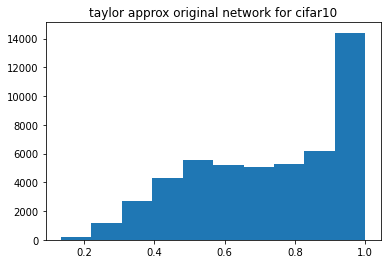

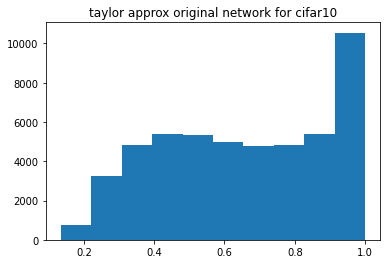

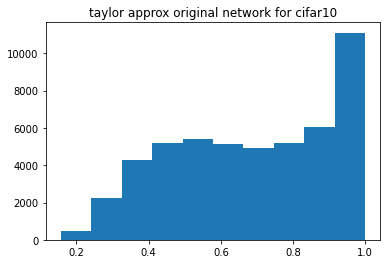

In [29]:
from utils import maxclass_hist
maxclass_hist(stealloader, net_HE, device, plt_title="taylor approx original network for cifar10")
maxclass_hist(stealloader, net_swd, device, plt_title="taylor approx original network for cifar10")
maxclass_hist(stealloader, net_fake2, device, plt_title="taylor approx original network for cifar10")

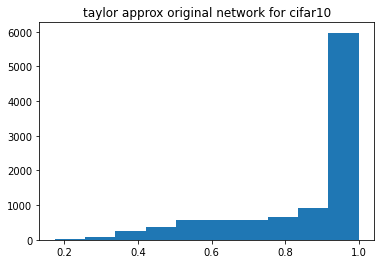

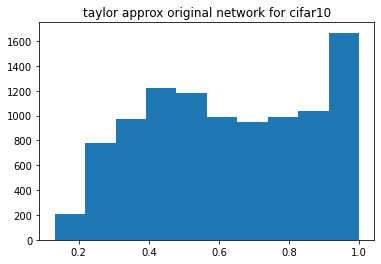

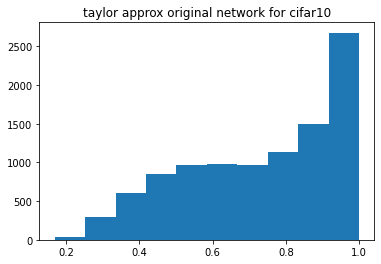

In [30]:
maxclass_hist(testloader, net_HE, device, plt_title="taylor approx original network for cifar10")
maxclass_hist(testloader, net_swd, device, plt_title="taylor approx original network for cifar10")
maxclass_hist(testloader, net_fake2, device, plt_title="taylor approx original network for cifar10")

In [65]:
from utils import maxclass_hist_comb

In [38]:
aa = next(iter(net_logit.classifier.modules()))[0]

In [42]:
aa.weight

Parameter containing:
tensor([[ 0.1533,  0.0957,  0.0912,  ..., -0.0624, -0.1008,  0.0148],
        [ 0.0280,  0.0060, -0.0003,  ..., -0.0167, -0.0061,  0.0584],
        [ 0.1074, -0.0021,  0.0076,  ...,  0.1137, -0.0320, -0.0237],
        ...,
        [ 0.0536,  0.1177,  0.0993,  ..., -0.0035,  0.0138, -0.0318],
        [-0.0616,  0.0889,  0.1201,  ...,  0.0582, -0.0223, -0.0560],
        [ 0.1061, -0.0747, -0.1292,  ..., -0.0150,  0.0012,  0.0345]],
       requires_grad=True)

In [45]:
def get_prediction(model, testloader, device):
    model.to(device).eval()
    preds = []
    with torch.no_grad():
        for data in testloader:
            preds.append(model(data[0].to(device)).detach().cpu())
        preds = torch.cat(preds,dim=0)
    return preds

In [49]:
logits

tensor([[ 99.7196,  17.1900,  20.9151,  ..., -25.1350,   1.3550,  -0.8058],
        [ 70.8414, 351.9266, -65.5912,  ..., -36.9416, 304.5785, -37.5630],
        [ 23.8117,  32.1893, -12.7723,  ...,  12.7096,  83.3991,  10.9220],
        ...,
        [-13.7051, -13.4647,  13.9033,  ...,  33.5407,   9.2430,  -6.1749],
        [175.1734, 262.2230,  30.4717,  ...,  -1.3624, -83.2219, -28.7416],
        [  0.3763,  -1.0869, -16.1330,  ..., 101.3450,  -4.0265,  -7.6392]])

In [54]:
torch.min(logits_fake,dim=1)[0]

tensor([ -22.5864,  -47.3721, -467.9579,  ..., -116.5464, -188.4706,
        -334.7144])

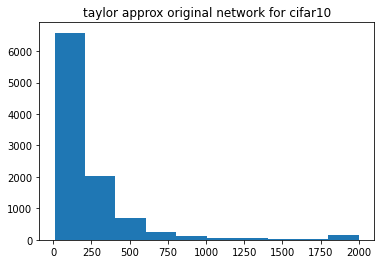

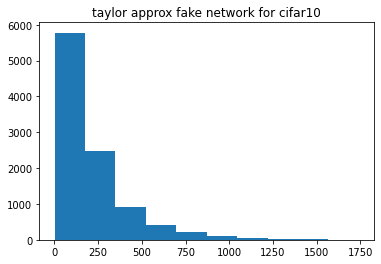

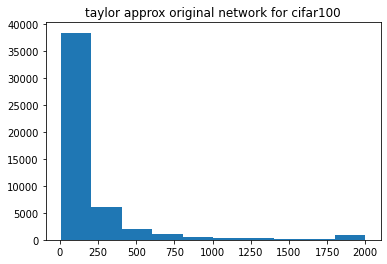

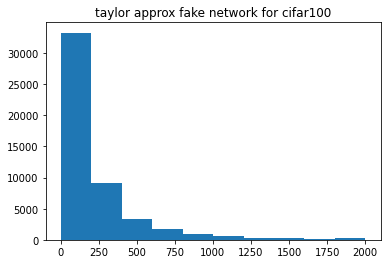

In [43]:
from utils import maxclass_hist, prediction_hist
maxclass_hist(testloader, net_logit, device, plt_title="taylor approx original network for cifar10",
              clipping=True, clip_vals=[None, 2000])
maxclass_hist(testloader, fake_logit_swd, device, plt_title="taylor approx fake network for cifar10",
              clipping=True, clip_vals=[None, 2000])

maxclass_hist(stealloader, net_logit, device, plt_title="taylor approx original network for cifar100",
              clipping=True, clip_vals=[None, 2000])
# maxclass_hist(stealloader, net_HE, device, plt_title="taylor approx original network for cifar100")
maxclass_hist(stealloader, fake_logit_swd, device, plt_title="taylor approx fake network for cifar100",
              clipping=True, clip_vals=[None, 2000])

# maxclass_hist(outlier_loader, net, device, plt_title="taylor approx original network for tinyimagenet")
# maxclass_hist(outlier_loader, fake_swd, device, plt_title="taylor approx fake network for tinyimagenet")

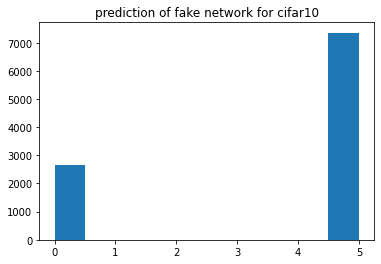

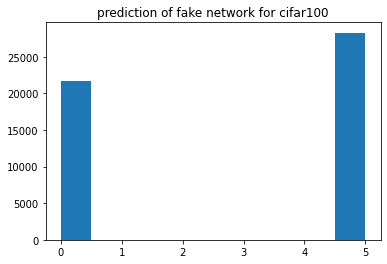

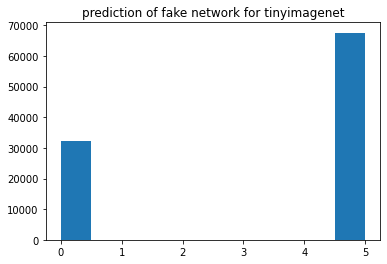

In [20]:
prediction_hist(testloader, fake_swd, device, plt_title="prediction of fake network for cifar10")
prediction_hist(stealloader, fake_swd, device, plt_title="prediction of fake network for cifar100")
prediction_hist(outlier_loader, fake_swd, device, plt_title="prediction of fake network for tinyimagenet")

## Taylor NLL with random label

In [30]:
from utils import make_randomlabel, train_model_NLL

In [31]:
net_random = Net()

In [32]:
random_loader = make_randomlabel(trainloader)
net_optim = optim.Adam(net_random.parameters(), lr=0.0001)

/home/srp/research/HEML/HEDL_inference/codes/utils/data_utils.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  randset = torch.utils.data.TensorDataset(torch.tensor(train_all[0]),randlabel.type(torch.LongTensor))


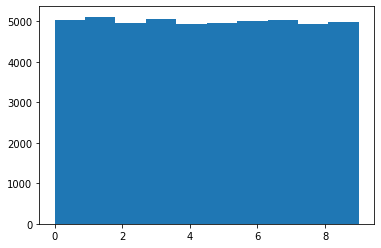

In [37]:
import matplotlib.pyplot as plt
plt.hist(random_loader.dataset.tensors[1].numpy())
plt.show()

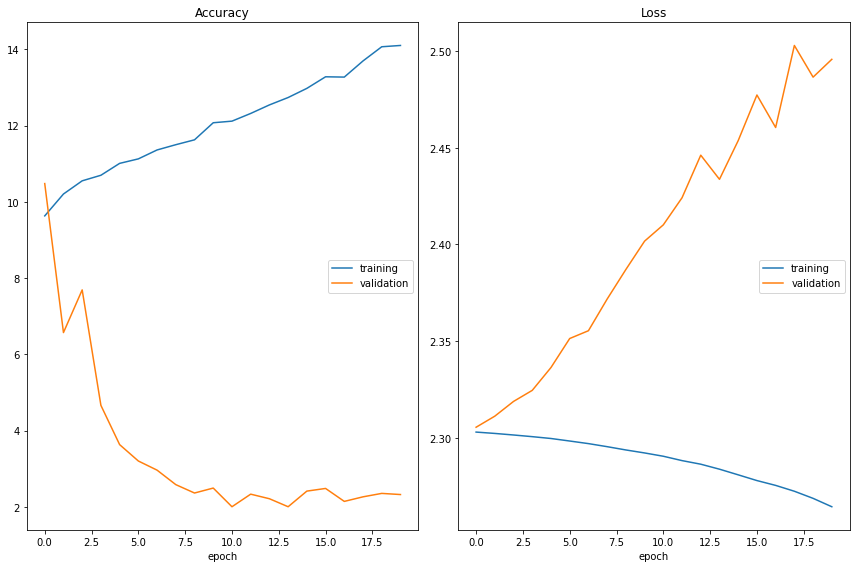

Accuracy
	training         	 (min:    9.632, max:   14.104, cur:   14.104)
	validation       	 (min:    2.000, max:   10.480, cur:    2.320)
Loss
	training         	 (min:    2.264, max:    2.303, cur:    2.264)
	validation       	 (min:    2.305, max:    2.503, cur:    2.496)


In [38]:
net_random, logs_net = train_model_NLL(net_random, random_loader, net_optim, device, epochs=20, 
                 test_loader = testloader, save_dir = "../results",save_model="cifar_fake_random_net.pth")

### load model

In [60]:
import os
net_random.load_state_dict(torch.load(os.path.join("../results","cifar_fake_random_net.pth")))

<All keys matched successfully>

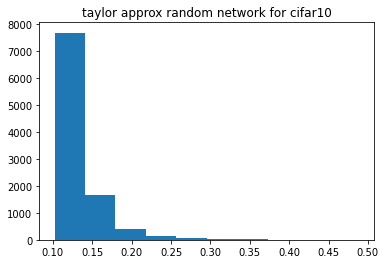

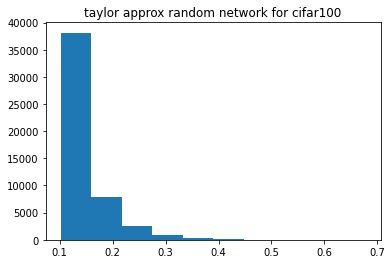

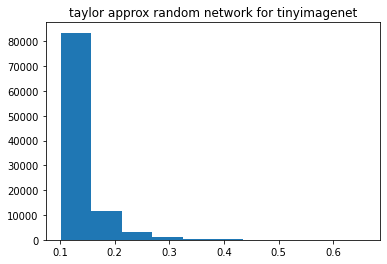

In [39]:
from utils import maxclass_hist, prediction_hist
maxclass_hist(testloader, net_random, device, plt_title="taylor approx random network for cifar10")
maxclass_hist(stealloader, net_random, device, plt_title="taylor approx random network for cifar100")
maxclass_hist(outlier_loader, net_random, device, plt_title="taylor approx random network for tinyimagenet")

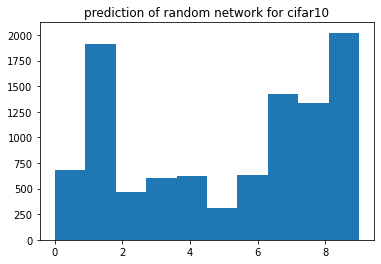

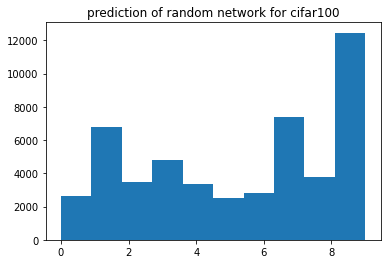

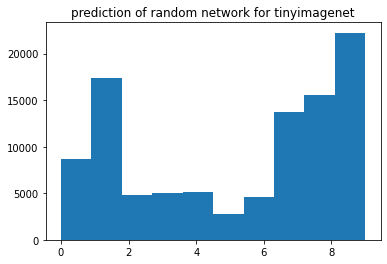

In [40]:
prediction_hist(testloader, net_random, device, plt_title="prediction of random network for cifar10")
prediction_hist(stealloader, net_random, device, plt_title="prediction of random network for cifar100")
prediction_hist(outlier_loader, net_random, device, plt_title="prediction of random network for tinyimagenet")